In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from s_dbw import S_Dbw
import matplotlib.patches as mpatches
import time


In [2]:
# resets index after selections have been made
def resetindex(data):
    data=data.reset_index()
    data=data.drop('index', axis=1)
    return data

In [3]:
#reduces the data set to the first m iterations
def firstiterations(m,data):
    i=0
    j=0
    n=len(data.index)    
    while i<n:
        if  (data.iat[j,10]>m):
            data=data.drop(i, axis=0)
            i=i+1
        else:
            i=i+1
            j=j+1
    data=resetindex(data)
    return data

In [4]:
# Generate a Series with a specific length, so that all residuals of one parameter combination are in one line
def GenerateSeries(source, Length):
    output=source.iloc[:,[4,5]]
    output=output.drop_duplicates()
    output=resetindex(output)
    for j in range(1, Length+1):
        output[f'ResidualNorm{j}']=0.0
        for i in range(len(output.index)):
            Abfrage=source.query( f"`Droptol`=={output.iat[i,0]} and `Fillfactor`=={output.iat[i,1]} and Iterations=={j}")
            if len(Abfrage.index)==1:
                output.iat[i,j+1]=Abfrage.iat[0,8]
            elif len(Abfrage.index)>1:
                raise Exception("Multiple instances with same Droptol, Fillfactor and Iteration within one Beta")
    return output

In [5]:
#dfall=pd.read_csv('thermal1.txt', sep='\t', header=None)
dfall = pd.read_csv("Ex38.csv", sep=',', header=None,error_bad_lines=False)

dfall = dfall.rename(columns={0: 'Fillfactor', 1: 'Droptol',2: 'Nonzeros',3:'ResidualNorm1',5:'ResidualNorm2',7:'ResidualNorm3',9:'ResidualNorm4',11:'ResidualNorm5',13:'ResidualNorm6',15:'ResidualNorm7',17:'ResidualNorm8',19:'ResidualNorm9'})
dfall=dfall.fillna(0)

In [6]:
temp,columnscount=dfall.shape

In [7]:
columnscount

1003

In [8]:
FirstIterations=dfall[['Droptol','Fillfactor','ResidualNorm1','ResidualNorm2','ResidualNorm3','ResidualNorm4','ResidualNorm5','ResidualNorm6','ResidualNorm7','ResidualNorm8','ResidualNorm9']]
FirstIterations

,Droptol,Fillfactor,ResidualNorm1,ResidualNorm2,ResidualNorm3,ResidualNorm4,ResidualNorm5,ResidualNorm6,ResidualNorm7,ResidualNorm8,ResidualNorm9
0,-12,1,0.447249,0.441938,0.376512,0.331290,0.329790,0.357312,0.390667,0.411149,0.414386
1,-10,1,0.447249,0.441938,0.376512,0.331290,0.329789,0.357307,0.390657,0.411131,0.414363
2,-8,1,0.447249,0.441938,0.376512,0.331290,0.329790,0.357312,0.390667,0.411146,0.414380
3,-6,1,0.447249,0.441938,0.376512,0.331290,0.329791,0.357312,0.390670,0.411156,0.414399
4,-4,1,0.447249,0.441962,0.376505,0.331071,0.329294,0.356529,0.389744,0.410454,0.414274
...,...,...,...,...,...,...,...,...,...,...,...
76,-4,9,0.048839,0.047663,0.091963,0.076144,0.064967,0.043625,0.030814,0.023708,0.021687
77,-2,9,0.180564,0.110722,0.136573,0.103023,0.059106,0.060258,0.044026,0.030617,0.021076
78,0,9,0.531647,0.417940,0.311855,0.267911,0.240302,0.240145,0.220123,0.202538,0.198105
79,2,9,0.531647,0.417940,0.311855,0.267911,0.240302,0.240145,0.220123,0.202538,0.198105


In [9]:
start=time.time()

basis=FirstIterations.query("(Fillfactor==1 or Fillfactor==5 or Fillfactor==9) and\
(Droptol==-12 or Droptol==-4 or Droptol==4)")
basis=resetindex(basis)
basis


for rounds in range(1,100):    
    print(rounds)

    #test different combinations and compute S_Dbw score
    if rounds<3:
        clustermax=6
    else: clustermax=12
        
    optimizationgrid=np.zeros([7,clustermax-2])
    for SeriesLength in range(3,10):
        for clustercount in range(2,clustermax):
            #series=GenerateSeries(basis,SeriesLength)
            series=basis.iloc[:,0:2+SeriesLength]
            scaler = preprocessing.StandardScaler().fit(series.iloc[:,2:(2+SeriesLength)])
            scaled_clusterdata=scaler.transform(series.iloc[:,2:(2+SeriesLength)])
            kmeans=KMeans(n_clusters=clustercount)
            y=kmeans.fit_predict(scaled_clusterdata)
            UnsortedClusters=y
            labels=kmeans.labels_
            score = S_Dbw(scaled_clusterdata, labels, centers_id=None, method='Halkidi', alg_noise='bind', centr='mean', nearest_centr=True, metric='euclidean')
            optimizationgrid[SeriesLength-3,clustercount-2]= score
        
    # take best option based on the score      
    minima=np.argwhere((optimizationgrid == np.min(optimizationgrid)))
    minima=minima[0]
    SeriesLength=minima[0]+3
    clustercount=minima[1]+2
    

    #series=GenerateSeries(basis,SeriesLength)
    series=basis.iloc[:,0:2+SeriesLength]
    scaler = preprocessing.StandardScaler().fit(series.iloc[:,2:(2+SeriesLength)])
    scaled_clusterdata=scaler.transform(series.iloc[:,2:(2+SeriesLength)])
    kmeans=KMeans(n_clusters=clustercount)
    y=kmeans.fit_predict(scaled_clusterdata)
    UnsortedClusters=y
    labels=kmeans.labels_
    score = S_Dbw(scaled_clusterdata, labels, centers_id=None, method='Halkidi', alg_noise='bind',\
                  centr='mean', nearest_centr=True, metric='euclidean')



    #Take best combination and sort clusters
    SortingValues=np.zeros(clustercount)
    SortData=pd.DataFrame(series[f'ResidualNorm{SeriesLength}'])
    SortData['UnsortedClusters']=y
    for i in range(0,clustercount):
        ResOfCluster=SortData.query(f'UnsortedClusters=={i}')
        sums=ResOfCluster[f"ResidualNorm{SeriesLength}"].sum()
        SortingValues[i]=sums/len(ResOfCluster.index)
    
    Sorting=np.argsort(np.argsort(SortingValues))
    Clusters=np.zeros(shape=len(UnsortedClusters))
    for i in range(0,len(Clusters)):
        Clusters[i]=Sorting[UnsortedClusters[i]]
    Clusters=np.int_(Clusters)
    series['Cluster']=Clusters


    Droptols=basis["Droptol"].unique()
    Droptols=np.sort(Droptols)
    minDroptol=Droptols[0]
    maxDroptol=Droptols[len(Droptols)-1]

    Fillfactors=basis["Fillfactor"].unique()
    Fillfactors=np.sort(Fillfactors)
    minFillfactor=Fillfactors[0]
    maxFillfactor=Fillfactors[len(Fillfactors)-1]
    
    
    tobedetermined=pd.DataFrame(columns=["Droptol","Fillfactor"])
    tobedetermined["Droptol"]=tobedetermined["Droptol"].astype(float)
    tobedetermined["Fillfactor"]=tobedetermined["Fillfactor"].astype(int)
    
    
    #vertical axis
    for i in range(0,len(Droptols)):
    
        #left and right boundary
        if (Droptols[i]==minDroptol or Droptols[i]==maxDroptol):
            
            #which points exist for a certain Droptol, sorted ascending by Fillfactor
            temp=(series.query(f"Droptol=={Droptols[i]}")).sort_values(by=["Fillfactor"])
            temp=resetindex(temp)
            for j in range(0,len(temp.index)-1):
                #comparison of pairs of direct point
                if temp.iat[j,SeriesLength+2]!=temp.iat[j+1,SeriesLength+2]:
                    tobedetermined=tobedetermined.append({'Droptol':temp.iat[j,0],'Fillfactor':math.floor((temp.iat[j,1]+temp.iat[j+1,1])/2)}, ignore_index=True)
                
        else:
            temp=(series.query(f"Droptol=={Droptols[i]}")).sort_values(by="Fillfactor")
            temp=resetindex(temp)
            curDroptol=Droptols[i]

        
            #look at points "above"
            for j in range(0,len(temp.index)):
            
                curFillfactor=temp.iat[j,1]
            
                if curFillfactor==maxFillfactor:
                    break
                
                optFillfactors=Fillfactors
                mask=(optFillfactors)>curFillfactor
                optFillfactors=optFillfactors[mask]
                optFillfactors=sorted(optFillfactors)
                
                for k in range(0,len(optFillfactors)):
                
                    if (series.query(f"Droptol=={curDroptol} and Fillfactor=={optFillfactors[k]}")).empty:
                        above=(series.query(f"Droptol>{curDroptol} and Fillfactor=={optFillfactors[k]}")).sort_values(by=["Droptol"])                    
                        under=(series.query(f"Droptol<{curDroptol} and Fillfactor=={optFillfactors[k]}")).sort_values(by=["Droptol"], ascending=False)
                        if (np.invert(above.empty) and np.invert(under.empty)):
                            above=resetindex(above)
                            under=resetindex(under)
                        
                            if (above.iat[0,SeriesLength+2]==under.iat[0,SeriesLength+2]):
                                if (above.iat[0,SeriesLength+2]!=temp.iat[j,SeriesLength+2]):
                                    if (math.floor((curFillfactor+optFillfactors[k])/2)!=minFillfactor):
                                        tobedetermined=tobedetermined.append({'Droptol':curDroptol,'Fillfactor':math.floor((curFillfactor+optFillfactors[k])/2)}, ignore_index=True)
                                break
                            
                    else:
                        if k<len(optFillfactors):
                            if temp.iat[j,SeriesLength+2]!=temp.iat[j+1,SeriesLength+2]:
                                if (math.floor((temp.iat[j,1]+temp.iat[j+1,1])/2)!=minFillfactor):
                                    tobedetermined=tobedetermined.append({'Droptol':temp.iat[j,0],'Fillfactor':math.floor((temp.iat[j,1]+temp.iat[j+1,1])/2)}, ignore_index=True)
                                break
                            elif temp.iat[j,SeriesLength+2]==temp.iat[j+1,SeriesLength+2]:
                                break
        
            #look at points "under"
            for j in range(0,len(temp.index)):
                
                curFillfactor=temp.iat[j,1]

                if curFillfactor==minFillfactor:
                    break
                
                optFillfactors=Fillfactors
                mask=(optFillfactors)<curFillfactor
                optFillfactors=optFillfactors[mask]
                optFillfactors=sorted(optFillfactors, reverse=True)

                for k in range(0,len(optFillfactors)):
                    
                    if (series.query(f"Droptol=={curDroptol} and Fillfactor=={optFillfactors[k]}")).empty:
                        above=(series.query(f"Droptol>{curDroptol} and Fillfactor=={optFillfactors[k]}")).sort_values(by=["Droptol"])                    
                        under=(series.query(f"Droptol<{curDroptol} and Fillfactor=={optFillfactors[k]}")).sort_values(by=["Droptol"], ascending=False)
                        if (np.invert(above.empty) and np.invert(under.empty)):
                            above=resetindex(above)
                            under=resetindex(under)
                        
                            if (above.iat[0,SeriesLength+2]==under.iat[0,SeriesLength+2]):
                                if (above.iat[0,SeriesLength+2]!=temp.iat[j,SeriesLength+2]):
                                    if (math.floor((curFillfactor+optFillfactors[k])/2)!=minFillfactor):
                                        tobedetermined=tobedetermined.append({'Droptol':curDroptol,'Fillfactor':math.floor((curFillfactor+optFillfactors[k])/2)}, ignore_index=True)
                                break
                    else:
                        if k<len(optFillfactors):
                            if temp.iat[j,SeriesLength+2]!=temp.iat[j-1,SeriesLength+2]:
                                if (math.floor((temp.iat[j,1]+temp.iat[j-1,1])/2)!=minFillfactor):
                                    tobedetermined=tobedetermined.append({'Droptol':temp.iat[j,0],'Fillfactor':math.floor((temp.iat[j,1]+temp.iat[j-1,1])/2)}, ignore_index=True)
                                break
                            elif temp.iat[j,SeriesLength+2]==temp.iat[j-1,SeriesLength+2]:
                                break
                        
    
    
    
    
    
    
    #horizontal axis
    for i in range(0,len(Fillfactors)):
    
        #upper and lower boundary
        if (Fillfactors[i]==minFillfactor or Fillfactors[i]==maxFillfactor):
            #which points exist for a certain Fillfactor, sorted ascending by Droptol
            temp=(series.query(f"Fillfactor=={Fillfactors[i]}")).sort_values(by=["Droptol"])
            temp=resetindex(temp)
            for j in range(0,len(temp.index)-1):
                #comparison of pairs of direct point
                if temp.iat[j,SeriesLength+2]!=temp.iat[j+1,SeriesLength+2]:
                    tobedetermined=tobedetermined.append({'Droptol':math.floor((temp.iat[j,0]+temp.iat[j+1,0])/4)*2,'Fillfactor':temp.iat[j,1]}, ignore_index=True)
            
        else:
            temp=(series.query(f"Fillfactor=={Fillfactors[i]}")).sort_values(by="Droptol")
            temp=resetindex(temp)
            curFillfactor=Fillfactors[i]
        
            #look at points "to the right"
            for j in range(0,len(temp.index)):
            
                curDroptol=temp.iat[j,0]

                if curDroptol==maxDroptol:
                    break
                
                optDroptols=Droptols
                mask=(optDroptols)>curDroptol
                optDroptols=optDroptols[mask]
                optDroptols=sorted(optDroptols)
            
                for k in range(0,len(optDroptols)):

                    if (series.query(f"Droptol=={optDroptols[k]} and Fillfactor=={curFillfactor}")).empty:
                        above=(series.query(f"Droptol=={optDroptols[k]} and Fillfactor>{curFillfactor}")).sort_values(by=["Fillfactor"])                    
                        under=(series.query(f"Droptol=={optDroptols[k]} and Fillfactor<{curFillfactor}")).sort_values(by=["Fillfactor"], ascending=False)

                        if (np.invert(above.empty) and np.invert(under.empty)):
                            above=resetindex(above)
                            under=resetindex(under)
                        
                            if (above.iat[0,SeriesLength+2]==under.iat[0,SeriesLength+2]):
                                if (above.iat[0,SeriesLength+2]!=temp.iat[j,SeriesLength+2]):
                                    if (math.floor((curDroptol+optDroptols[k])/4)*2!=minDroptol):
                                        tobedetermined=tobedetermined.append({'Droptol':math.floor((curDroptol+optDroptols[k])/4)*2,'Fillfactor':curFillfactor}, ignore_index=True)
                                break
                    else:
                        if k<len(optDroptols):
                            if temp.iat[j,SeriesLength+2]!=temp.iat[j+1,SeriesLength+2]:
                                if (math.floor((temp.iat[j,0]+temp.iat[j+1,0])/4)*2!=minDroptol):
                                    tobedetermined=tobedetermined.append({'Droptol':math.floor((temp.iat[j,0]+temp.iat[j+1,0])/4)*2,'Fillfactor':temp.iat[j,1]}, ignore_index=True)
                                break
                            elif temp.iat[j,SeriesLength+2]==temp.iat[j+1,SeriesLength+2]:
                                break
        
        
            #look at points "to the left"
            for j in range(0,len(temp.index)):
                
                curDroptol=temp.iat[j,0]

                if curDroptol==minDroptol:
                    break
                
                optDroptols=Droptols
                mask=(optDroptols)<curDroptol
                optDroptols=optDroptols[mask]
                optDroptols=sorted(optDroptols, reverse=True)
            
                for k in range(0,len(optDroptols)):

                    if (series.query(f"Droptol=={optDroptols[k]} and Fillfactor=={curFillfactor}")).empty:
                        above=(series.query(f"Droptol=={optDroptols[k]} and Fillfactor>{curFillfactor}")).sort_values(by=["Fillfactor"])                    
                        under=(series.query(f"Droptol=={optDroptols[k]} and Fillfactor<{curFillfactor}")).sort_values(by=["Fillfactor"], ascending=False)
                    
                        if (np.invert(above.empty) and np.invert(under.empty)):
                            above=resetindex(above)
                            under=resetindex(under)
                        
                            if (above.iat[0,SeriesLength+2]==under.iat[0,SeriesLength+2]):
                                if (above.iat[0,SeriesLength+2]!=temp.iat[j,SeriesLength+2]):
                                    if (math.floor((curDroptol +optDroptols[k])/4)*2!=minDroptol):
                                        tobedetermined=tobedetermined.append({'Droptol':math.floor((curDroptol + optDroptols[k])/4)*2 ,'Fillfactor': curFillfactor}, ignore_index=True)
                                break
                    else:
                        if k<len(optDroptols):
                            if temp.iat[j,SeriesLength+2]!=temp.iat[j-1,SeriesLength+2]:
                                if (math.floor((temp.iat[j,0]+temp.iat[j-1,0])/4)*2!=minDroptol):
                                    tobedetermined=tobedetermined.append({'Droptol':math.floor((temp.iat[j,0]+temp.iat[j-1,0])/4)*2 ,'Fillfactor':temp.iat[j,1]}, ignore_index=True)
                                break
                            elif temp.iat[j,SeriesLength+2]==temp.iat[j-1,SeriesLength+2]:
                                break
                                
                                
    tobedetermined=tobedetermined.drop_duplicates()
    tobedetermined=resetindex(tobedetermined)                            
                                
    points=basis[["Droptol","Fillfactor"]]
    points = points.drop_duplicates()
    points = resetindex(points)

    NumberOldPoints=len(points.index)

    points=[points,tobedetermined]
    points = pd.concat(points)
    points = points.drop_duplicates()
    points = resetindex(points)
    NumberNewPoints=len(points.index)

    if NumberOldPoints==NumberNewPoints:
        stop=time.time()
        break
    else:        
        if len(points.index)>0:
            basis=FirstIterations.query(f"Droptol=={points.iat[0,0]} and Fillfactor=={points.iat[0,1]}")
            j=1
    
            while j<len(points.index):
                basisadd=FirstIterations.query(f"Droptol=={points.iat[j,0]} and Fillfactor=={points.iat[j,1]}")
                basis=[basis,basisadd]
                basis=pd.concat(basis)
                j=j+1
    
            basis=resetindex(basis)
                        
    
    

1
2
3
4
5
6


In [10]:
#probe time
print(stop-start)

16.384804487228394


<br>
<br>
<br>
<strong> Visualizing parameter space

In [11]:
list=['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16']
for cl in range(0,clustercount):
    vars()["PredictionGroup"+list[cl]]=series.query(f"`Cluster`=={cl}") #" and ILUTNonzeros<{ILUTNonzerosLimit}")

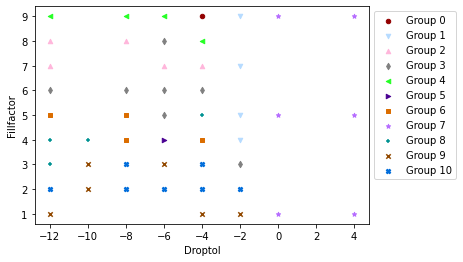

In [12]:
ax = PredictionGroup0.plot(kind='scatter', x='Droptol', y='Fillfactor',color='#920000', label='Group 0');
PredictionGroup1.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "v", color='#b6dbff', label='Group 1', ax=ax);
if clustercount>2:
    PredictionGroup2.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "^", color='#ffb6db', label='Group 2', ax=ax);
    if clustercount>3:
        PredictionGroup3.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "d",color='grey', label='Group 3', ax=ax);
        if clustercount>4:
            PredictionGroup4.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "<",color='#24ff24', label='Group 4', ax=ax);
            if clustercount>5:
                PredictionGroup5.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= ">",color='#490092', label='Group 5', ax=ax);
                if clustercount>6:
                    PredictionGroup6.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "s",color='#db6d00', label='Group 6', ax=ax);
                    if clustercount>7:
                        PredictionGroup7.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "*",color='#b66dff', label='Group 7', ax=ax);
                        if clustercount>8:
                            PredictionGroup8.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "+",color='#009292', label='Group 8', ax=ax);
                            if clustercount>9:
                                PredictionGroup9.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "x", color='#924900', label='Group 9', ax=ax);
                                if clustercount>10:
                                    PredictionGroup10.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "X",color='#006ddb', label='Group 10', ax=ax);
                                    if clustercount>11:
                                        PredictionGroup11.plot(kind='scatter', x='Droptol', y='Fillfactor',marker= "D",color='#004949', label='Group 11', ax=ax);
#ax.set_xscale('log')
ax.legend(bbox_to_anchor=(1.0, 1.0))
#plt.title(f"Beta=1e{int(math.log10(beta))}, full dataset, all iterations, ILUTNonzeros<{ILUTNonzerosLimit}")
plt.show()

<br>
<br>
<br>
<strong> Visualizing trajectories

In [13]:
dfall

,Fillfactor,Droptol,Nonzeros,ResidualNorm1,4,ResidualNorm2,6,ResidualNorm3,8,ResidualNorm4,...,993,994,995,996,997,998,999,1000,1001,1002
0,1,-12,95662,0.447249,0.066396,0.441938,0.067859,0.376512,0.069318,0.331290,...,7.278119e-01,1.686823,7.279128e-01,1.688791,7.280052e-01,1.690749,7.280892e-01,1.692707,7.281650e-01,1.694683
1,1,-10,95621,0.447249,0.059687,0.441938,0.061716,0.376512,0.063659,0.331290,...,7.272824e-01,2.664365,7.273892e-01,2.667420,7.274877e-01,2.670458,7.275777e-01,2.673497,7.276595e-01,2.676529
2,1,-8,95633,0.447249,0.085309,0.441938,0.088407,0.376512,0.091949,0.331290,...,7.278640e-01,2.341169,7.279716e-01,2.344002,7.280708e-01,2.347158,7.281617e-01,2.349975,7.282443e-01,2.352758
3,1,-6,95664,0.447249,0.100834,0.441938,0.104823,0.376512,0.108505,0.331290,...,7.279406e-01,2.021226,7.280390e-01,2.024991,7.281289e-01,2.028847,7.282103e-01,2.032730,7.282833e-01,2.036365
4,1,-4,95587,0.447249,0.120717,0.441962,0.126478,0.376505,0.131831,0.331071,...,7.288429e-01,2.141016,7.290537e-01,2.143026,7.292564e-01,2.145010,7.294510e-01,2.147090,7.296374e-01,2.149182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,9,-4,651204,0.048839,0.143420,0.047663,0.147305,0.091963,0.150599,0.076144,...,1.269108e-04,1.909067,1.271713e-04,1.912259,1.274464e-04,1.915482,1.277355e-04,1.918632,1.280381e-04,1.921787
77,9,-2,234965,0.180564,0.108337,0.110722,0.110869,0.136573,0.113069,0.103023,...,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
78,9,0,31332,0.531647,0.035682,0.417940,0.037125,0.311855,0.038522,0.267911,...,1.257950e-10,0.804245,1.355765e-10,0.805639,1.400002e-10,0.807032,1.419654e-10,0.808420,1.459823e-10,0.809828
79,9,2,31332,0.531647,0.034845,0.417940,0.036203,0.311855,0.037522,0.267911,...,1.257950e-10,0.786104,1.355765e-10,0.787420,1.400002e-10,0.788766,1.419654e-10,0.790145,1.459823e-10,0.791536


In [14]:
probed=dfall.query(f"Droptol=={series.iat[0,0]} and Fillfactor=={series.iat[0,1]}")
j=1

while j<len(series.index):
    probedadd=dfall.query(f"Droptol=={series.iat[j,0]} and Fillfactor=={series.iat[j,1]}")
    probed=[probed,probedadd]
    probed=pd.concat(probed)
    j=j+1
    
probed=resetindex(probed)
probed["Cluster"]=series['Cluster']

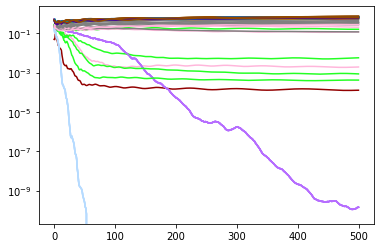

In [15]:


markers=["o","v", "^", "d","<", ">","s","*","+" ,"x", "X" ,"D"]
                                                     
colors=['#920000','#b6dbff','#ffb6db','grey','#24ff24','#490092','#db6d00','#b66dff','#009292','#924900','#006ddb','#004949']
lengthdfall=len(probed.index)
liste=[None] * lengthdfall

for i in range(0,lengthdfall):
    liste[i-1]=probed.iloc[i,3:columnscount:2]
for i in range(0,lengthdfall):
    liste[i-1].plot(use_index=False, color=colors[probed.iloc[i,columnscount]])#,marker=markers[dfall.iloc[i,columnscount]]),#, label=f'Group {df.iloc[i,1003]}')
#affiliation=[None] * 11
#for i in range(0,10):
#    affiliation[i]= mpatches.Patch(color=colors[i], label=f'Group {i}')

#plt.legend(handles=affiliation,bbox_to_anchor=(1.0, 1.0))
plt.yscale("log")
#plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.show()

In [16]:
probed.iloc[:,20].sum()

8.276709794998167